## Лабораторная работа №4 по крусу ТМО
### "Подготовка обучающей и тестовой выборки, кросс-валидация и подбор гиперпараметров на примере метода ближайших соседей".

In [2]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.model_selection import KFold, RepeatedKFold, LeaveOneOut, LeavePOut, ShuffleSplit, StratifiedKFold
from sklearn.metrics import accuracy_score, balanced_accuracy_score
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_squared_log_error, median_absolute_error, r2_score 
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import learning_curve, validation_curve
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline 
sns.set(style="ticks")

### 1. Загрузка и первичный анализ данных
Выбран набор данных [Болезни сердца UCI](https://www.kaggle.com/ronitf/heart-disease-uci).

In [3]:
data = pd.read_csv('../datasets/heart.csv', sep=',')
data.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


In [4]:
data.shape

(303, 14)

In [5]:
data.isnull().sum()

age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          0
thal        0
target      0
dtype: int64

In [6]:
data.corr()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
age,1.000000,-0.098447,-0.068653,0.279351,0.213678,0.121308,-0.116211,-0.398522,0.096801,0.210013,-0.168814,0.276326,0.068001,-0.225439
sex,-0.098447,1.000000,-0.049353,-0.056769,-0.197912,0.045032,-0.058196,-0.044020,0.141664,0.096093,-0.030711,0.118261,0.210041,-0.280937
cp,-0.068653,-0.049353,1.000000,0.047608,-0.076904,0.094444,0.044421,0.295762,-0.394280,-0.149230,0.119717,-0.181053,-0.161736,0.433798
trestbps,0.279351,-0.056769,0.047608,1.000000,0.123174,0.177531,-0.114103,-0.046698,0.067616,0.193216,-0.121475,0.101389,0.062210,-0.144931
chol,0.213678,-0.197912,-0.076904,0.123174,1.000000,0.013294,-0.151040,-0.009940,0.067023,0.053952,-0.004038,0.070511,0.098803,-0.085239
fbs,0.121308,0.045032,0.094444,0.177531,0.013294,1.000000,-0.084189,-0.008567,0.025665,0.005747,-0.059894,0.137979,-0.032019,-0.028046
restecg,-0.116211,-0.058196,0.044421,-0.114103,-0.151040,-0.084189,1.000000,0.044123,-0.070733,-0.058770,0.093045,-0.072042,-0.011981,0.137230
thalach,-0.398522,-0.044020,0.295762,-0.046698,-0.009940,-0.008567,0.044123,1.000000,-0.378812,-0.344187,0.386784,-0.213177,-0.096439,0.421741
exang,0.096801,0.141664,-0.394280,0.067616,0.067023,0.025665,-0.070733,-0.378812,1.000000,0.288223,-0.257748,0.115739,0.206754,-0.436757
oldpeak,0.210013,0.096093,-0.149230,0.193216,0.053952,0.005747,-0.058770,-0.344187,0.288223,1.000000,-0.577537,0.222682,0.210244,-0.430696


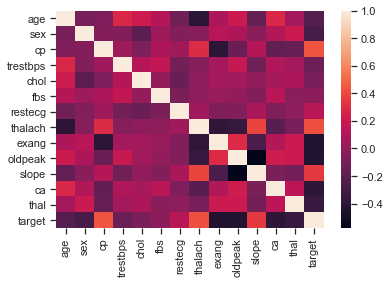

In [7]:
sns.heatmap(data.corr())

Основываясь на корреляционном анализе, можно сделать вывод:
   * Целевой признак больше всего коррелирует с "cp", "exang", "oldpeak" и "ca". Их точно нужно оставить в модели.

### 2. Разделение выборки на обучающую и тестовую

In [119]:
# выбор нужных столбцов
X = data[['cp','exang','oldpeak', 'ca']]
y = data.target
heart_X_train, heart_X_test, heart_y_train, heart_y_test = train_test_split(X, y, test_size=0.3, random_state=1)

In [120]:
# нормализация столбцов X
sc = StandardScaler()
heart_X_train = sc.fit_transform(heart_X_train)
heart_X_test = sc.fit_transform(heart_X_test)
heart_X_train

array([[ 1.99223435,  1.43960542,  0.35630932,  0.29558577],
       [-0.94758246, -0.69463478, -0.93178576,  0.29558577],
       [-0.94758246,  1.43960542,  1.09236365,  0.29558577],
       [ 1.99223435, -0.69463478, -0.10372464, -0.6990838 ],
       [-0.94758246,  1.43960542, -0.19573143, -0.6990838 ],
       [ 1.01229541, -0.69463478,  1.09236365,  0.29558577],
       [-0.94758246,  1.43960542, -0.83977897,  0.29558577],
       [ 1.99223435, -0.69463478,  0.72433649,  1.29025534],
       [ 1.99223435, -0.69463478, -0.01171785, -0.6990838 ],
       [-0.94758246,  1.43960542, -0.93178576, -0.6990838 ],
       [-0.94758246,  1.43960542,  4.22059457, -0.6990838 ],
       [ 0.03235647, -0.69463478,  0.72433649, -0.6990838 ],
       [ 1.01229541, -0.69463478, -0.93178576, -0.6990838 ],
       [-0.94758246,  1.43960542,  1.92042478, -0.6990838 ],
       [ 0.03235647, -0.69463478, -0.5637586 ,  3.27959448],
       [ 0.03235647, -0.69463478, -0.01171785, -0.6990838 ],
       [-0.94758246,  1.

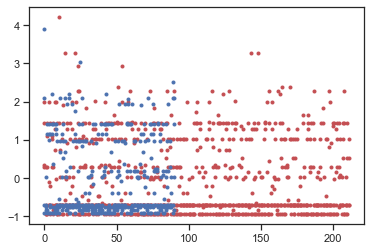

In [121]:
# визуализация выборки
plt.plot(heart_X_train,'r.', \
        heart_X_test, 'b.')
plt.show()

### 3. Обучение модели ближайших соседей для произвольно заданного гиперпараметра K. Оценка качества модели с помощью подходящих для задачи метрик.

In [122]:
# Первичное обучение модели и оценка качества
# 50 ближайших соседей - недообучение
cl1_1 = KNeighborsClassifier(n_neighbors=50)
cl1_1.fit(heart_X_train, heart_y_train)
target1_0 = cl1_1.predict(heart_X_train)
target1_1 = cl1_1.predict(heart_X_test)
accuracy_score(heart_y_train, target1_0), accuracy_score(heart_y_test, target1_1)

(0.8113207547169812, 0.7032967032967034)

In [142]:
# 24 ближайших соседа (приближаемся к балансу между смещением и дисперсией)
cl1_2 = KNeighborsClassifier(n_neighbors=24)
cl1_2.fit(heart_X_train, heart_y_train)
target1_0 = cl1_2.predict(heart_X_train)
target1_1 = cl1_2.predict(heart_X_test)
accuracy_score(heart_y_train, target1_0), accuracy_score(heart_y_test, target1_1)

(0.8160377358490566, 0.7582417582417582)

In [143]:
# 1 ближайший сосед - переобучение
cl1_3 = KNeighborsClassifier(n_neighbors=1)
cl1_3.fit(heart_X_train, heart_y_train)
target1_0 = cl1_3.predict(heart_X_train)
target1_1 = cl1_3.predict(heart_X_test)
accuracy_score(heart_y_train, target1_0), accuracy_score(heart_y_test, target1_1)

(0.9575471698113207, 0.6923076923076923)

### 4. Построение модели и оценка качества модели с использованием кросс-валидации.

In [144]:
scores = cross_val_score(KNeighborsClassifier(n_neighbors=10), 
                         X, y, 
                         cv=LeaveOneOut())
scores, np.mean(scores)

(array([1., 0., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 0., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 0., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 0., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 0., 1., 1., 1., 0.,
        0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1.,
        1., 1., 0., 0., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 0., 1., 1.,
        1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        0., 0., 0., 1., 1., 1., 1., 0., 1., 1., 1., 1., 0., 1., 1., 1., 1.,
        1., 0., 0., 1., 1., 1., 1., 0., 1., 0., 1., 1., 1., 1., 1., 1., 0.,
        1., 1., 1., 1., 1., 1., 0., 1., 0., 1., 1., 1., 0., 1., 1., 1., 1.,
        1., 

In [145]:
# использование метрики f1
scores = cross_val_score(KNeighborsClassifier(n_neighbors=10), 
                         X, y, cv=3,
                        scoring='f1_weighted')
scores, np.mean(scores)

(array([0.82017436, 0.81202965, 0.80019373]), 0.8107992468636055)

Использование метода cross_validate:

In [146]:
scoring = {'precision': 'precision_weighted', 
           'recall': 'recall_weighted',
           'f1': 'f1_weighted'}

In [147]:
scores = cross_validate(KNeighborsClassifier(n_neighbors=2), 
                        X, y, scoring=scoring, 
                        cv=3, return_train_score=True)
scores

{'fit_time': array([0.00300622, 0.00299311, 0.00299215]),
 'score_time': array([0.00896335, 0.00897408, 0.00797868]),
 'test_precision': array([0.69609461, 0.74440183, 0.81166902]),
 'train_precision': array([0.87622058, 0.89776878, 0.86876427]),
 'test_recall': array([0.68316832, 0.73267327, 0.81188119]),
 'train_recall': array([0.86633663, 0.89108911, 0.85643564]),
 'test_f1': array([0.6828577 , 0.73267327, 0.81169495]),
 'train_f1': array([0.86648407, 0.89128146, 0.85649546])}

### 5. Подбор гиперпараметра K с использованием GridSearchCV и кросс-валидации.

In [148]:
n_range = np.array(range(5,55,5))
tuned_parameters = [{'n_neighbors': n_range}]
tuned_parameters

[{'n_neighbors': array([ 5, 10, 15, 20, 25, 30, 35, 40, 45, 50])}]

In [149]:
%%time
clf_gs = GridSearchCV(KNeighborsClassifier(), tuned_parameters, cv=5, scoring='accuracy')
clf_gs.fit(heart_X_train, heart_y_train)

Wall time: 215 ms


GridSearchCV(cv=5, error_score=nan,
             estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30,
                                            metric='minkowski',
                                            metric_params=None, n_jobs=None,
                                            n_neighbors=5, p=2,
                                            weights='uniform'),
             iid='deprecated', n_jobs=None,
             param_grid=[{'n_neighbors': array([ 5, 10, 15, 20, 25, 30, 35, 40, 45, 50])}],
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='accuracy', verbose=0)

In [150]:
clf_gs.cv_results_

{'mean_fit_time': array([0.00139742, 0.0009963 , 0.0009975 , 0.00080819, 0.        ,
        0.        , 0.        , 0.002     , 0.        , 0.00400009]),
 'std_fit_time': array([4.90234921e-04, 1.29186794e-06, 1.78416128e-07, 4.04556255e-04,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 3.99999619e-03,
        0.00000000e+00, 4.89909164e-03]),
 'mean_score_time': array([0.00299039, 0.00363545, 0.00239348, 0.00119653, 0.00400009,
        0.00199528, 0.0036129 , 0.00199966, 0.0039947 , 0.00200391]),
 'std_score_time': array([0.00063076, 0.0007755 , 0.00048832, 0.00097696, 0.00489909,
        0.00399055, 0.00446978, 0.00399933, 0.0048925 , 0.00400782]),
 'param_n_neighbors': masked_array(data=[5, 10, 15, 20, 25, 30, 35, 40, 45, 50],
              mask=[False, False, False, False, False, False, False, False,
                    False, False],
        fill_value='?',
             dtype=object),
 'params': [{'n_neighbors': 5},
  {'n_neighbors': 10},
  {'n_neighbors': 15},
  {'n_ne

In [151]:
# Лучшая модель
clf_gs.best_estimator_

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

In [152]:
# Лучшее значение метрики
clf_gs.best_score_

0.8305647840531561

In [153]:
# Лучшее значение параметров
clf_gs.best_params_

{'n_neighbors': 5}

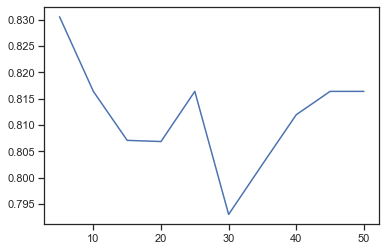

In [154]:
# Изменение качества на тестовой выборке в зависимости от К-соседей
plt.plot(n_range, clf_gs.cv_results_['mean_test_score'])

### 6.Обучение модели и оценка качества с учетом подобранных гиперпараметров

In [155]:
clf_gs.best_estimator_.fit(heart_X_train, heart_y_train)
target2_0 = clf_gs.best_estimator_.predict(heart_X_train)
target2_1 = clf_gs.best_estimator_.predict(heart_X_test)

In [156]:
# Новое качество модели
accuracy_score(heart_y_train, target2_0), accuracy_score(heart_y_test, target2_1)

(0.8537735849056604, 0.7142857142857143)

In [157]:
# Качество модели до подбора гиперпараметров
accuracy_score(heart_y_train, target1_0), accuracy_score(heart_y_test, target1_1)

(0.9575471698113207, 0.6923076923076923)